In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import h5py

import cooler

In [26]:
# the following directive activates inline plotting
%matplotlib inline

In [27]:
# constants
TASK_SIZE = 100

In [28]:
def plot_hic(matrix):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    im = ax.matshow(np.log10(matrix), cmap='YlOrRd')
    fig.colorbar(im)

In [29]:
def mark_nans_as_zeros(matrix):
    # we think NaN == 0 for now
    matrix[np.isnan(matrix)] = 0

In [30]:
def mark_defective_as_nan(matrix):
    # row or column is considered to be defective if less than 5% of values are non-zero
    # Since we work with the small and relatively good region of the entire Hi-C map, threshold is set to 20%
    # Don't forget to set back to 5% when working with the entire map, because leaving 20% clears all the map
    DEFECT_THRESHOLD = 20
    
    # non-zero values will give True
    boolean_matrix = matrix != 0
    
    defective_rows = np.where(np.sum(boolean_matrix, axis = 1) < ((boolean_matrix.shape[1] / 100) * DEFECT_THRESHOLD))
    defective_columns = np.where(np.sum(boolean_matrix, axis = 0) < ((boolean_matrix.shape[0] / 100) * DEFECT_THRESHOLD))
    
    # place nan value for all defective rows
    for defective_row in defective_rows:
        matrix[defective_row, :] = np.nan
        
    for defective_column in defective_columns:
        matrix[:, defective_column] = np.nan
        

In [31]:
# import hi-c data (drosophila embryo)
filepath = "Kc167.10000.cool"
c = cooler.Cooler(filepath)
arr = c.matrix()

current_matrix = arr[0:TASK_SIZE, 0:TASK_SIZE]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


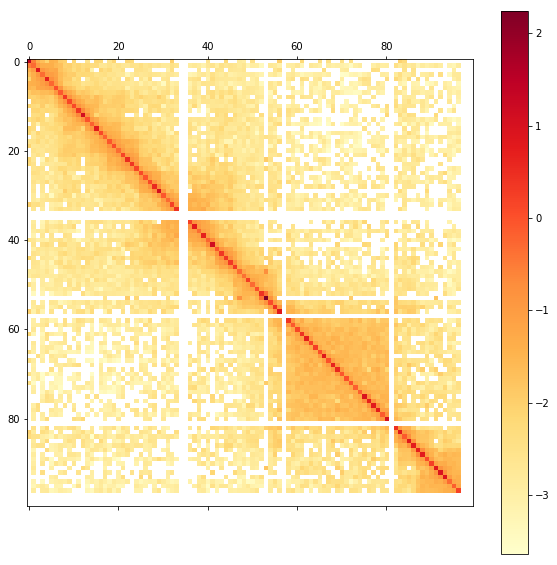

In [32]:
# plots before data cleaning
plot_hic(current_matrix)

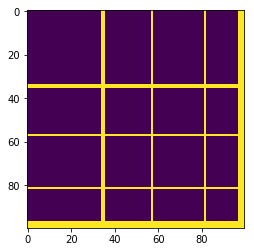

In [33]:
plt.imshow(np.isnan(current_matrix))

In [34]:
# clean the data
mark_nans_as_zeros(current_matrix)
mark_defective_as_nan(current_matrix)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


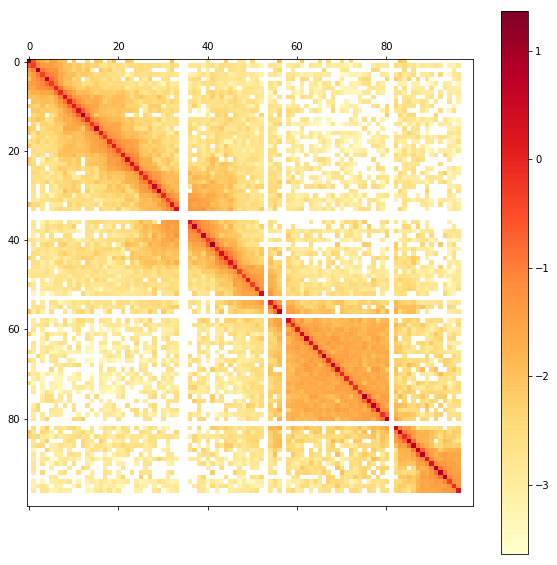

In [35]:
# plots after data cleaning
plot_hic(current_matrix)

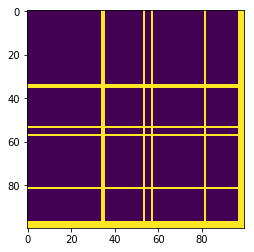

In [36]:
plt.imshow(np.isnan(current_matrix))

In [ ]:
# TODO: random select of regions?
# when select, put -1 there to not select this region twice
# also it would be beautiful in plt imshow
# so that we can tune then how close they are to the center
# plt.imshow(np.isnan(current_matrix)  current_matrix == -1)
isnan_matrix = np.isnan(current_matrix).astype(int)
isnan_matrix[600:610, ] = -1
plt.imshow(isnan_matrix)